# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../../Projects/data/WADI/

 table_WADI.pdf       'WADI.A1_9 Oct 2017'    WADI_attackdataLABLE.csv
 WADI_14days_new.csv  'WADI.A2_19 Nov 2019'


In [2]:
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T


from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

In [3]:
seed_num = 6493
set_seed(seed_num)

### Dataset:

In [4]:
# pd.reset_option('dispay.max_rows')

In [5]:
# pd.set_option('display.max_rows', 133)
# pd.set_option('display.max_columns', 133)

In [6]:
na_columns = ['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS', '1_LS_001_AL', '1_LS_001_AL', 'Row', 'Date', 'Time']

In [7]:
df = pd.read_csv('../../../Projects/data/WADI/WADI_14days_new.csv')
df.columns = df.columns.str.strip()
df = df.drop(columns=na_columns, inplace=False)
grouping_array = np.arange(len(df)) // 5
df = df.groupby(grouping_array).median()
df = df.ffill(inplace=False)
df = df.astype('float')
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df))
validation_range = int(0.18 * df.shape[0])
allowed_range = int(0.82 * df.shape[0])
validation_start_point = random.randint(0, allowed_range)
validation_set = df[validation_start_point: validation_start_point + validation_range]
train_1 = df[:validation_start_point]
train_2 = df[validation_start_point + validation_range:]
train_set = pd.concat([train_1, train_2], axis=0)
del train_1, train_2

In [8]:
validation_start_point

58916

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [10]:
window_size = 64

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096 * 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [11]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, window_size)
        self.conv2 = GCNLayer(window_size, window_size // 2)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(window_size // 2 * num_nodes, window_size * 2 // 3 * num_nodes),
            nn.ReLU(),
            nn.Linear(window_size * 2 // 3 * num_nodes, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [12]:
num_nodes = 122 # number of nodes
alpha = 0.30 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 50

In [13]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [14]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=64, out_features=64, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=64, out_features=32, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(122, 64)
      (e2): Embedding(122, 64)
      (l1): Linear(in_features=64, out_features=64, bias=True)
      (l2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=3904, out_features=5124, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5124, out_features=7808, bias=True)
  )
)

In [15]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [16]:
# from torch.utils.tensorboard import SummaryWriter
model_path = 'wadi_model_latest_experiments_' + str(seed_num) + '.pth'

In [17]:
%%time
best_val = None
patience = 10
AE1_val_history = []
AE1_train_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    AE1.train()
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    AE1.eval()
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.5f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.5f}')
    # if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.004:
    #     continue
    val_er = round(AE1_val_history[-1], 5)
    train_er = round(torch.stack(running_loss_AE1).mean().item(), 5)
    if best_val:
        if val_er > best_val:
            patience = patience - 1
            if patience == 0:
                break;
    if best_val:
        if best_val > val_er:
            best_val = val_er
            torch.save(AE1.state_dict(), model_path)
    else:
        best_val = val_er

Epoch: 0 ---> Val loss: AE1 0.55681
Train loss: AE1 0.61389
Epoch: 1 ---> Val loss: AE1 0.43924
Train loss: AE1 0.46194
Epoch: 2 ---> Val loss: AE1 0.37240
Train loss: AE1 0.37221
Epoch: 3 ---> Val loss: AE1 0.32543
Train loss: AE1 0.30188
Epoch: 4 ---> Val loss: AE1 0.26946
Train loss: AE1 0.24894
Epoch: 5 ---> Val loss: AE1 0.24135
Train loss: AE1 0.21363
Epoch: 6 ---> Val loss: AE1 0.20870
Train loss: AE1 0.18667
Epoch: 7 ---> Val loss: AE1 0.17898
Train loss: AE1 0.16421
Epoch: 8 ---> Val loss: AE1 0.15844
Train loss: AE1 0.14530
Epoch: 9 ---> Val loss: AE1 0.13829
Train loss: AE1 0.12690
Epoch: 10 ---> Val loss: AE1 0.12668
Train loss: AE1 0.11522
Epoch: 11 ---> Val loss: AE1 0.11397
Train loss: AE1 0.10371
Epoch: 12 ---> Val loss: AE1 0.10863
Train loss: AE1 0.09643
Epoch: 13 ---> Val loss: AE1 0.10027
Train loss: AE1 0.08996
Epoch: 14 ---> Val loss: AE1 0.09762
Train loss: AE1 0.08695
Epoch: 15 ---> Val loss: AE1 0.09231
Train loss: AE1 0.08148
Epoch: 16 ---> Val loss: AE1 0.089

In [18]:
AE1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Testing

In [19]:
df_test = pd.read_csv('../../../Projects/data/WADI/WADI_attackdataLABLE.csv')
df_test = df_test[:-2]
df_test.columns = df_test.columns.str.strip()
df_test = df_test.drop(columns=na_columns, inplace=False)
df_test = df_test.astype('float')
grouping_array = np.arange(len(df_test)) // 5
df_test = df_test.groupby(grouping_array).mean()
labels = df_test['Attack LABLE (1:No Attack, -1:Attack)']
df_test = df_test.drop(columns=['Attack LABLE (1:No Attack, -1:Attack)'], inplace=False)
df_test = df_test.ffill(inplace=False)
test_normalized = pd.DataFrame(mm.fit_transform(df_test))

In [20]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [21]:
def testing(test_loader):
    results=[]
    AE1.eval()
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [22]:
labels = labels.values
labels = [0 if (lab == 1) else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [23]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [24]:
results=testing(test_loader)

In [25]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

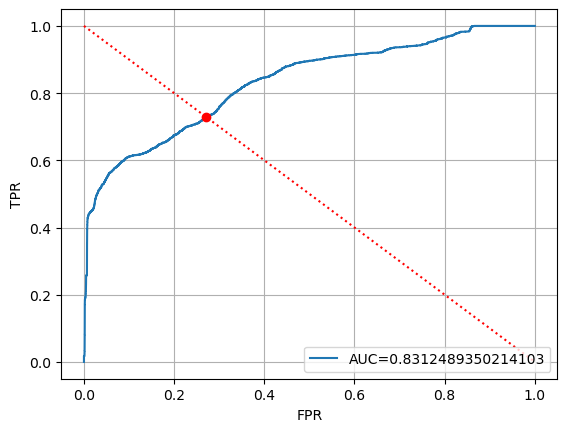

array([0.05252687], dtype=float32)

In [26]:
threshold = ROC(y_test,y_pred)
threshold

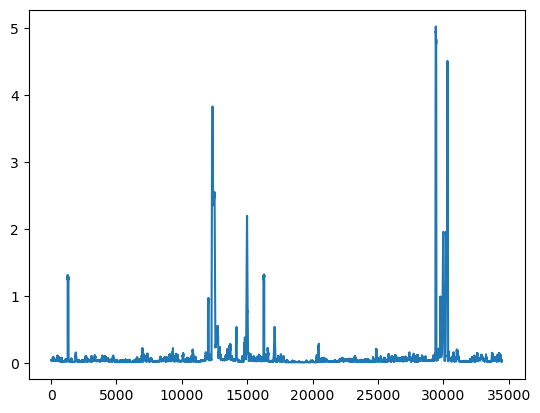

In [27]:
plt.plot(y_pred)

In [28]:
def print_metrics(y_pred, y_true):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f'False positive: {FP} \nTrue positive: {TP} \nFalse negative: {FN} \nTrue negative: {TN}')
    print(f'Precision: {100 * precision} \nRecall: {100 * recall}')
    print(f'F1: {F1 * 100}')

def print_detection_percentage(y_pred_int, y_test, anomaly_segments):
    for index, (i, j) in enumerate(anomaly_segments):
        cur_pred = y_pred_int[i:j]
        cur_true = y_test[i:j]
        print(f'Segment number {index} has {np.sum((cur_pred < cur_true).astype(int))} points undetected while total is {len(cur_pred)}')

best: 0.22941176470588234 F1: 0.565742397137746
False positive: 329 
True positive: 1265 
False negative: 1613 
True negative: 31290
Precision: 79.36010037641155 
Recall: 43.954134815844334
F1: 56.5742397137746


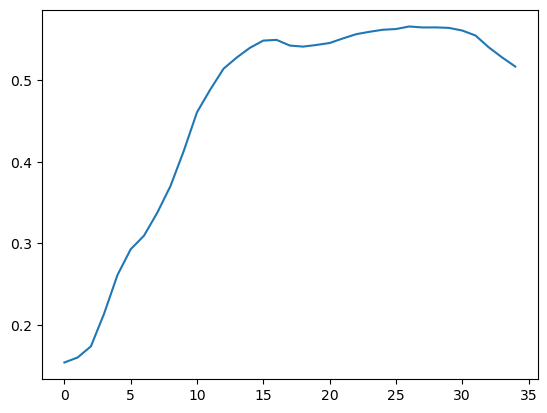

In [29]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.3, 35):
    y_pred_int = (y_pred > initial_y + inc).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)
y_pred_int = (y_pred > best).astype(int)
print_metrics(y_pred_int, y_test)

In [30]:
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

In [31]:
y_pred_int = np.array((y_pred > best).astype(int))
latency_times = []
for index, (i, j) in enumerate(anomaly_segments):
    current_arr = y_pred_int[i: j]
    first_detection = np.where(current_arr == 1)[0]
    if first_detection.shape[0] > 0:
        latency_times.append(first_detection[0])
print(np.mean(latency_times))

36.6


In [32]:
for i, j in anomaly_segments:
    if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
        y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
print_metrics(y_pred_int, y_test)

False positive: 329 
True positive: 1647 
False negative: 1231 
True negative: 31290
Precision: 83.3502024291498 
Recall: 57.22724113968033
F1: 67.86155747836835


In [33]:
for i, j in anomaly_segments:
    if np.sum(y_pred_int[i: j]) > 0:
        y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
print_metrics(y_pred_int, y_test)

False positive: 329 
True positive: 1889 
False negative: 989 
True negative: 31290
Precision: 85.1668169522092 
Recall: 65.63585823488533
F1: 74.13657770800629


# Point Adjust

## One point

best: 0.14705882352941177 F1: 0.7462892647566448


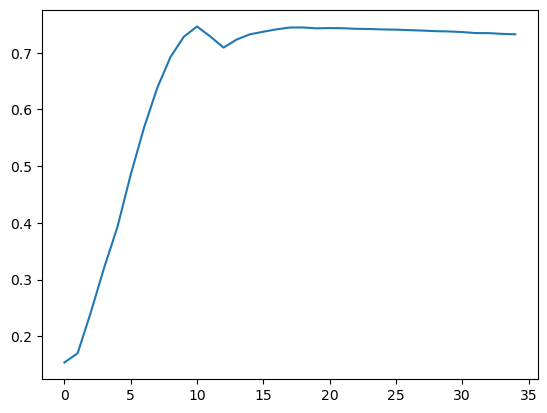

In [34]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 0.5, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

## Point adjust 20%

best: 0.2647058823529412 F1: 0.6804558885605742


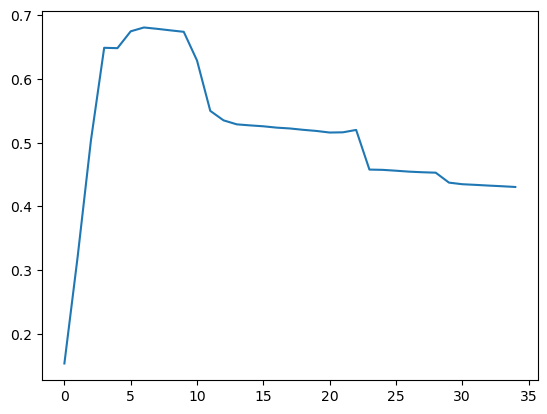

In [35]:
ff = 0
f_history = []
initial_y = 0
best = -1
for inc in np.linspace(0, 1.5, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [36]:
threshold = np.percentile(y_pred, 75)

excesses = y_pred[y_pred > threshold] - threshold

shape, loc, scale = stats.genpareto.fit(excesses)

desired_quantile = 0.80
quantile = stats.genpareto.ppf(desired_quantile, shape, loc=loc, scale=scale)

final_threshold = threshold + quantile
print(f"Final threshold for anomaly detection: {final_threshold}")
print(f'Initial threshold: {threshold}')
print(f'quantile found: {quantile}')

predicted_labels = (y_pred > final_threshold).astype(int)

Final threshold for anomaly detection: 0.21993881666283024
Initial threshold: 0.06332634389400482
quantile found: 0.15661247276882542


In [37]:
print((classification_report(labels, predicted_labels)))

ValueError: Found input variables with inconsistent numbers of samples: [34561, 34497]

In [ ]:
f1_score(labels, predicted_labels)

In [ ]:
# torch.save(AE1.state_dict(), 'GAE_77_Directed_200_epochs.pth')

In [ ]:
# AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

In [ ]:
# def testing(loader, alpha=.5, beta=.5):
#     results=[]
#     with torch.no_grad():
#         for batch in loader:
#             w1=AE1(batch)
#             results.append(torch.mean((batch-w1)**2, axis=1))
#     return results

# def get_threshold(val_loader):
#     recon_errors = testing(val_loader)
#     complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
#                                     recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
#     return np.max(complete_vals, axis=0)

In [ ]:
# thresholds = get_threshold(validation_loader)
# results=testing(test_loader, alpha=0.3, beta=0.7)
# y_pred=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(), 
#                        results[-1].view(-1, num_nodes).detach().cpu().numpy()])

In [ ]:
# factor = 1

In [ ]:
# factor = 720
# res = y_pred > (thresholds * factor)
# boo = np.any(res, axis = 1)
# verdicts = [1 if elem else 0 for elem in boo]
# conf_matrix = confusion_matrix(y_test, verdicts)
# TP = conf_matrix[1, 1]
# TN = conf_matrix[0, 0]
# FP = conf_matrix[0, 1]
# FN = conf_matrix[1, 0]
# F1 = f1_score(y_test, verdicts)
# precision = precision_score(y_test, verdicts)
# recall = recall_score(y_test, verdicts)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", F1)
# print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')
# print(f'Factor is: {factor}')

In [ ]:
sum(p.numel() for p in AE1.parameters() if p.requires_grad)